앞서 배운 $x$가 1개인 선형 회귀를 단순 선형 회귀(Simple Linear Regression)이라고 합니다.
이번 챕터에서는 다수의 $x$로부터 $y$를 예측하는 다중 선형 회귀(Multivariable Linear Regression)에 대해서 이해합니다.

# 1. 데이터에 대한 이해(Data Definition)

---

다음과 같은 훈련 데이터가 있습니다. 앞서 배운 단순 선형 회귀와 다른 점은 독립 변수 $x$의 개수가 이제 1개가 아닌 3개라는 점입니다. 3개의 퀴즈 점수로부터 최종 점수를 예측하는 모델을 만들어보겠습니다.

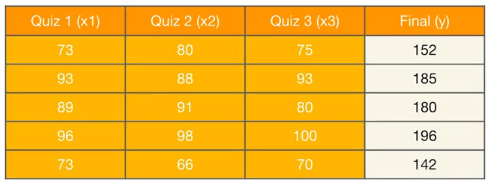

독립 변수 $x$의 개수가 3개므로 이를 수식으로 표현하면 아래와 같습니다.

$$
H(x) = w_{1}x_{1} + w_{2}x_{2} + w_{3}x_{3} + b
$$

# 2. 파이토치로 구현하기

---

우선 필요한 도구들을 임포트하고 랜덤 시드를 고정합니다.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
torch.manual_seed(1)

이제 훈련 데이터를 선언해보겠습니다.

$$
H(x) = w_{1}x_{1} + w_{2}x_{2} + w_{3}x_{3} + b
$$

위의 식을 보면 이번에는 단순 선형 회귀와 다르게 $x$의 개수가 3개입니다. 그러니까 $x$를 3개 선언합니다.

In [3]:
# 훈련 데이터
x1_train = torch.FloatTensor([[73], [93], [89], [96], [73]])
x2_train = torch.FloatTensor([[80], [88], [91], [98], [66]])
x3_train = torch.FloatTensor([[75], [93], [90], [100], [70]])
y_train = torch.FloatTensor([[152], [185], [180], [196], [142]])

이제 가중치 $w$와 편향 $b$를 선언합니다. 가중치 $w$도 3개 선언해주어야 합니다.

In [5]:
# 가중치 w와 편향 b 초기화
w1 = torch.zeros(1, requires_grad=True)
w2 = torch.zeros(1, requires_grad=True)
w3 = torch.zeros(1, requires_grad=True)
b = torch.zeros(1, requires_grad=True)

이제 가설, 비용 함수, 옵티마이저를 선언한 후에 경사 하강법을 1,000회 반복합니다.

In [6]:
# optimizer 설정
optimizer = optim.SGD([w1, w2, w3, b], lr=1e-5)

nb_epochs = 1000
for epoch in range(nb_epochs + 1):

    # H(x) 계산
    hypothesis = x1_train * w1 + x2_train * w2 + x3_train * w3 + b

    # cost 계산
    cost = torch.mean((hypothesis - y_train) ** 2)

    # cost로 H(x) 개선
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    # 100번마다 로그 출력
    if epoch % 100 == 0:
        print('Epoch {:4d}/{} w1: {:.3f} w2: {:.3f} w3: {:.3f} b: {:.3f} Cost: {:.6f}'.format(
            epoch, nb_epochs, w1.item(), w2.item(), w3.item(), b.item(), cost.item()
        ))


Epoch    0/1000 w1: 0.294 w2: 0.294 w3: 0.297 b: 0.003 Cost: 29661.800781
Epoch  100/1000 w1: 0.674 w2: 0.661 w3: 0.676 b: 0.008 Cost: 1.563634
Epoch  200/1000 w1: 0.679 w2: 0.655 w3: 0.677 b: 0.008 Cost: 1.497607
Epoch  300/1000 w1: 0.684 w2: 0.649 w3: 0.677 b: 0.008 Cost: 1.435026
Epoch  400/1000 w1: 0.689 w2: 0.643 w3: 0.678 b: 0.008 Cost: 1.375730
Epoch  500/1000 w1: 0.694 w2: 0.638 w3: 0.678 b: 0.009 Cost: 1.319511
Epoch  600/1000 w1: 0.699 w2: 0.633 w3: 0.679 b: 0.009 Cost: 1.266222
Epoch  700/1000 w1: 0.704 w2: 0.627 w3: 0.679 b: 0.009 Cost: 1.215696
Epoch  800/1000 w1: 0.709 w2: 0.622 w3: 0.679 b: 0.009 Cost: 1.167818
Epoch  900/1000 w1: 0.713 w2: 0.617 w3: 0.680 b: 0.009 Cost: 1.122429
Epoch 1000/1000 w1: 0.718 w2: 0.613 w3: 0.680 b: 0.009 Cost: 1.079378


위의 경우 가설을 선언하는 부분인 hypothesis = x1_train * w1 + x2_train * w2 + x3_train * w3 + b에서도 x_train의 개수만큼 w와 곱해주도록 작성해준 것을 확인할 수 있습니다.

# 3. 벡터와 행렬 연산으로 바꾸기

---

위의 코드를 개선할 수 있는 부분이 있습니다. 이번에는 $x$의 개수가 3개였으니까 x1_train, x2_train, x3_train와 w1, w2, w3를 일일히 선언해주었습니다. 그런데 $x$의 개수가 1,000개라고 가정해봅시다. 위와 같은 방식을 고수할 경우 x_train1 ~ x_train1000을 전부 선언하고, w1 ~ w1000을 전부 선언해야 합니다. 다시 말해 $x$와 $w$ 변수 선언만 총 합 2,000개를 해야합니다. 또한 가설을 선언하는 부분에서도 마찬가지로 x_train과 w의 곱셈이 이루어지는 항을 1,000개를 작성해야 합니다. 이는 굉장히 비효율적입니다.
 
 이를 해결하기 위해 행렬 곱셈 연산(또는 벡터의 내적)을 사용합니다.
 
 + **행렬의 곱셈 과정에서 이루어지는 벡터 연산을 벡터의 내적(Dot Product)이라고 합니다.**
 
 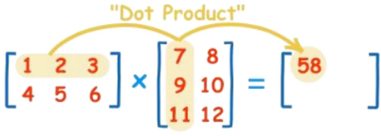
 
 위의 그림은 행렬 곱셈 연산 과정에서 벡터의 내적으로 1 × 7 + 2 × 9 + 3 × 11 = 58이 되는 과정을 보여줍니다.

이 행렬 연산이 어떻게 현재 배우고 있는 가설과 상관이 있다는 걸까요?
바로 가설을 벡터와 행렬 연산으로 표현할 수 있기 때문입니다.

## 1) 벡터 연산으로 이해하기

$$
H(X) = w_{1}x_{1} + w_{2}x_{2} + w_{3}x_{3}
$$

위 식은 아래와 같이 두 벡터의 내적으로 표현할 수 있습니다.

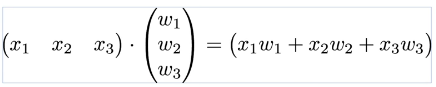

두 벡터를 각각 $X$와 $W$로 표현한다면, 가설은 다음과 같습니다.

$$
H(X) = XW
$$

$x$의 개수가 3개였음에도 이제는 $X$와 $W$라는 두 개의 변수로 표현된 것을 볼 수 있습니다.

## 2) 행렬 연산으로 이해하기

훈련 데이터를 살펴보고, 벡터와 행렬 연산을 통해 가설 $H(X)$를 표현해보겠습니다.

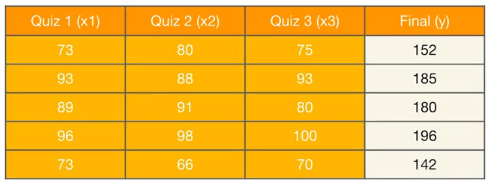

전체 훈련 데이터의 개수를 셀 수 있는 1개의 단위를 샘플(sample)이라고 합니다. 현재 샘플의 수는 총 5개입니다.
각 샘플에서 $y$를 결정하게 하는 각각의 독립 변수 $x$를 특성(feature)이라고 합니다. 현재 특성은 3개입니다.

이는 독립 변수 $x$들의 수가 (샘플의 수 × 특성의 수) = 15개임을 의미합니다. 독립 변수 $x$들을 (샘플의 수 × 특성의 수)의 크기를 가지는 하나의 행렬로 표현해봅시다. 그리고 이 행렬을 $X$라고 하겠습니다.

$$
\left(
    \begin{array}{c}
      x_{11}\ x_{12}\ x_{13}\ \\
      x_{21}\ x_{22}\ x_{23}\ \\
      x_{31}\ x_{32}\ x_{33}\ \\
      x_{41}\ x_{42}\ x_{43}\ \\
      x_{51}\ x_{52}\ x_{53}\ \\
    \end{array}
  \right)
$$
  
그리고 여기에 가중치 $w_{1}, w_{2}, w_{3}$을 원소로 하는 벡터를 $W$라 하고 이를 곱해보겠습니다.

$$
\left(
    \begin{array}{c}
      x_{11}\ x_{12}\ x_{13}\ \\
      x_{21}\ x_{22}\ x_{23}\ \\
      x_{31}\ x_{32}\ x_{33}\ \\
      x_{41}\ x_{42}\ x_{43}\ \\
      x_{51}\ x_{52}\ x_{53}\ \\
    \end{array}
  \right)
\left(
    \begin{array}{c}
      w_{1} \\
      w_{2} \\
      w_{3} \\
    \end{array}
  \right)
\  =
\left(
    \begin{array}{c}
      x_{11}w_{1}+ x_{12}w_{2}+ x_{13}w_{3}\ \\
      x_{21}w_{1}+ x_{22}w_{2}+ x_{23}w_{3}\ \\
      x_{31}w_{1}+ x_{32}w_{2}+ x_{33}w_{3}\ \\
      x_{41}w_{1}+ x_{42}w_{2}+ x_{43}w_{3}\ \\
      x_{51}w_{1}+ x_{52}w_{2}+ x_{53}w_{3}\ \\
    \end{array}
  \right)
$$

위의 식은 결과적으로 다음과 같습니다.

$$
H(X) = XW
$$

이 가설에 각 샘플에 더해지는 편향 $b$를 추가해봅시다. 샘플 수만큼의 차원을 가지는 편향 벡터 $B$를 만들어 더합니다.

$$
\left(
    \begin{array}{c}
      x_{11}\ x_{12}\ x_{13}\ \\
      x_{21}\ x_{22}\ x_{23}\ \\
      x_{31}\ x_{32}\ x_{33}\ \\
      x_{41}\ x_{42}\ x_{43}\ \\
      x_{51}\ x_{52}\ x_{53}\ \\
    \end{array}
  \right)
\left(
    \begin{array}{c}
      w_{1} \\
      w_{2} \\
      w_{3} \\
    \end{array}
  \right)
+
\left(
    \begin{array}{c}
      b \\
      b \\
      b \\
      b \\
      b \\
    \end{array}
  \right)
 \ =
\left(
    \begin{array}{c}
      x_{11}w_{1}+ x_{12}w_{2}+ x_{13}w_{3} + b\ \\
      x_{21}w_{1}+ x_{22}w_{2}+ x_{23}w_{3} + b\ \\
      x_{31}w_{1}+ x_{32}w_{2}+ x_{33}w_{3} + b\ \\
      x_{41}w_{1}+ x_{42}w_{2}+ x_{43}w_{3} + b\ \\
      x_{51}w_{1}+ x_{52}w_{2}+ x_{53}w_{3} + b\ \\
    \end{array}
  \right)
$$

위의 식은 결과적으로 다음과 같습니다.

$H(X) = XW + B$

결과적으로 전체 훈련 데이터의 가설 연산을 3개의 변수만으로 표현하였습니다.
이와 같이 벡터와 행렬 연산은 식을 간단하게 해줄 뿐만 아니라 다수의 샘플의 병렬 연산이므로 속도의 이점을 가집니다.

이를 참고로 파이토치로 구현해봅시다.

# 4. 행렬 연산을 고려하여 파이토치로 구현하기

---

이번에는 행렬 연산을 고려하여 파이토치로 재구현해보겠습니다.  
이번에는 훈련 데이터 또한 행렬로 선언해야 합니다.

In [7]:
x_train  =  torch.FloatTensor([[73,  80,  75], 
                               [93,  88,  93], 
                               [89,  91,  80], 
                               [96,  98,  100],   
                               [73,  66,  70]])  
y_train  =  torch.FloatTensor([[152],  [185],  [180],  [196],  [142]])

In [8]:
print(x_train.shape)
print(y_train.shape)

torch.Size([5, 3])
torch.Size([5, 1])


각각 (5 × 3) 행렬과 (5 × 1) 행렬(또는 벡터)의 크기를 가집니다.  
이제 가중치 $W$와 편향 $b$를 선언합니다.

In [9]:
# 가중치와 편향 선언
W = torch.zeros((3, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

여기서 주목할 점은 가중치 $W$의 크기가 (3 × 1) 벡터라는 점입니다. 행렬의 곱셈이 성립되려면 곱셈의 좌측에 있는 행렬의 열의 크기와 우측에 있는 행렬의 행의 크기가 일치해야 합니다. 현재 X_train의 행렬의 크기는 (5 × 3)이며, $W$ 벡터의 크기는 (3 × 1)이므로 두 행렬과 벡터는 행렬곱이 가능합니다. 행렬곱으로 가설을 선언하면 아래와 같습니다.

In [10]:
hypothesis = x_train.matmul(W) + b

가설을 행렬곱으로 간단히 정의하였습니다. 이는 앞서 x_train과 w의 곱셈이 이루어지는 각 항을 전부 기재하여 가설을 선언했던 것과 대비됩니다. 이 경우, 사용자가 독립 변수 $x$
의 수를 후에 추가적으로 늘리거나 줄이더라도 위의 가설 선언 코드를 수정할 필요가 없습니다. 이제 해야할 일은 비용 함수와 옵티마이저를 정의하고, 정해진 에포크만큼 훈련을 진행하는 일입니다. 이를 반영한 전체 코드는 다음과 같습니다.

In [13]:
x_train  =  torch.FloatTensor([[73,  80,  75], 
                               [93,  88,  93], 
                               [89,  91,  80], 
                               [96,  98,  100],   
                               [73,  66,  70]])  
y_train  =  torch.FloatTensor([[152],  [185],  [180],  [196],  [142]])

# 모델 초기화
W = torch.zeros((3, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)
# optimizer 설정
optimizer = optim.SGD([W, b], lr=1e-5)

nb_epochs = 20
for epoch in range(nb_epochs + 1):

    # H(x) 계산
    # 편향 b는 브로드 캐스팅되어 각 샘플에 더해집니다.
    hypothesis = x_train.matmul(W) + b

    # cost 계산
    cost = torch.mean((hypothesis - y_train) ** 2)

    # cost로 H(x) 개선
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    print('Epoch {:4d}/{} hypothesis: {} Cost: {:.6f}'.format(
        epoch, nb_epochs, hypothesis.squeeze().detach(), cost.item()
    ))


Epoch    0/20 hypothesis: tensor([0., 0., 0., 0., 0.]) Cost: 29661.800781
Epoch    1/20 hypothesis: tensor([66.7178, 80.1701, 76.1025, 86.0194, 61.1565]) Cost: 9537.694336
Epoch    2/20 hypothesis: tensor([104.5421, 125.6208, 119.2478, 134.7861,  95.8280]) Cost: 3069.590820
Epoch    3/20 hypothesis: tensor([125.9858, 151.3882, 143.7087, 162.4333, 115.4844]) Cost: 990.670288
Epoch    4/20 hypothesis: tensor([138.1429, 165.9963, 157.5768, 178.1071, 126.6283]) Cost: 322.481873
Epoch    5/20 hypothesis: tensor([145.0350, 174.2780, 165.4395, 186.9928, 132.9461]) Cost: 107.717064
Epoch    6/20 hypothesis: tensor([148.9423, 178.9730, 169.8976, 192.0301, 136.5279]) Cost: 38.687496
Epoch    7/20 hypothesis: tensor([151.1574, 181.6346, 172.4254, 194.8856, 138.5585]) Cost: 16.499043
Epoch    8/20 hypothesis: tensor([152.4131, 183.1435, 173.8590, 196.5043, 139.7097]) Cost: 9.365656
Epoch    9/20 hypothesis: tensor([153.1250, 183.9988, 174.6723, 197.4217, 140.3625]) Cost: 7.071114
Epoch   10/20 hyp